In [61]:
initial_path = 'peptide-QML'
# initial_path = '..'

In [62]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import helper_classes as c
from my_code import pytorch_model as m
from my_code import quantum_nodes as q

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# name of the notebook
name_notebook = "sweep_12h_er_Xqm"

In [64]:
# sweep = c.Sweep(
#     name_notebook, 
#     initial_path=initial_path,
#     description="Try to find the best measurement and number of layers for the quantum block using Angle Encoding (repeating embedding) and embedding.",
#     repetitions=list(range(1, 3)),
#     n_layers_quantum_block=[2,10,20],
#     embedding_n_layers=[0,1,2,3],
#     embedding_dim=[1,5],
# )

In [65]:
# sweep.save()

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  

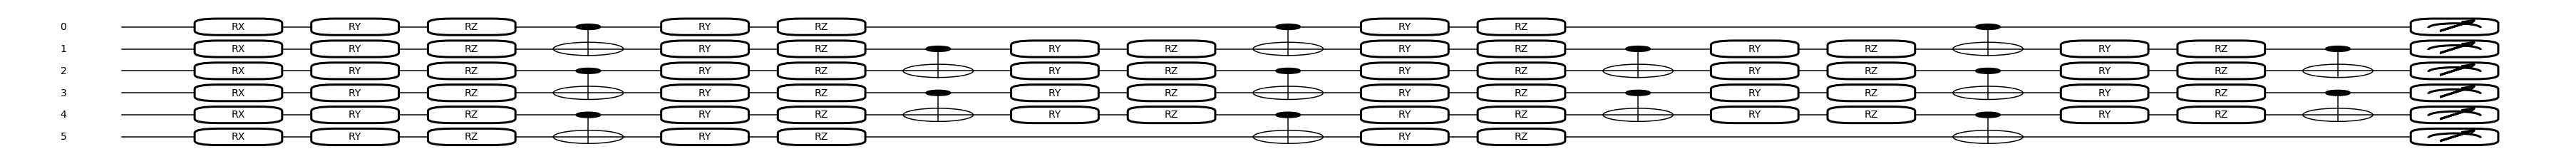

In [91]:
quantum_layer.draw()

In [88]:
import numpy as np
for x in model.state_dict().items():
    print(x[0], x[1].shape, np.prod(x[1].shape))

fc1.weight torch.Size([19, 1]) 19
fc3.0.weight torch.Size([6, 12]) 72
fc3.0.bias torch.Size([6]) 6
fc3.2.weight torch.Size([6, 6]) 36
fc3.2.bias torch.Size([6]) 6
fc4.block_weights torch.Size([40]) 40
fc4.final_weights torch.Size([20]) 20
fc5.0.weight torch.Size([6, 6]) 36
fc5.0.bias torch.Size([6]) 6
fc5.2.weight torch.Size([1, 6]) 6
fc5.2.bias torch.Size([1]) 1


248

In [73]:
# Get the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

# Get the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

# If you only want non-trainable parameters (often referred to as "frozen" parameters)
non_trainable_params = total_params - trainable_params
print(f"Non-trainable parameters: {non_trainable_params}")

Total parameters: 248
Trainable parameters: 248
Non-trainable parameters: 0


In [66]:
sweep = c.Sweep.load(file_name=name_notebook+"-2", day='0918', initial_path=initial_path)

In [67]:
for sweep_point in sweep:

    # print the point of the sweep
    sweep.print_sweep_status(sweep_point['idx'])

    # -- QUANTUM BLOCK -- #
    n_qubits = 6
    quantum_layer = q.circuit(
        n_qubits = n_qubits, 
        device = "default.qubit.torch",
        device_options = {'shots': None},
        embedding = q.parts.AngleEmbedding, 
        embedding_ansatz = q.parts.Ansatz_11,
        block_ansatz = q.parts.Ansatz_11,
        final_ansatz = q.parts.Ansatz_11, # TODO CHECK IF THIS IS THE BEST OPTION
        measurement = q.parts.Measurement('Z', 'all'),
        embedding_n_layers = sweep_point['embedding_n_layers'],
        different_inputs_per_layer = False,
        block_n_layers = sweep_point['n_layers_quantum_block'],
        # wrapper_qlayer = pw.QLayerEmpty,
    )

    # -- MODEL -- #                    
    class Model(m.Model):
        def __init__(self):
            super(Model, self).__init__()
            self.fc1 = m.nn.Embedding(num_embeddings=19, embedding_dim=sweep_point['embedding_dim'])
            self.fc2 = m.Reshape()
            self.fc3 = m.nn.Sequential(*[m.nn.Linear(12*sweep_point['embedding_dim'], 6), m.nn.Sigmoid(), m.nn.Linear(6, 6)])
            self.fc4 = quantum_layer()            
            self.fc5 = m.nn.Sequential(*[m.nn.Linear(6, 6), m.nn.Sigmoid(), m.nn.Linear(6, 1)])

        def forward(self, x):
            for i in range(1,6):
                x = getattr(self, 'fc{}'.format(i))(x)
            return x

    model = Model()

    # set quantum layer
    model.set_quantum_layer(quantum_layer)

    # set the name and path of the model
    model.set_name_and_path(name_notebook, initial_path)

    #set sweep point
    model.set_sweep_point(
        sweep_uuid = sweep.uuid,
        sweep_point = sweep_point,
        day=sweep.day
    )

    # -- TRAIN -- #
    model.optimize_params(
        #save info
        save_model_info = True,
        description = 'sweep with 12 amino acids and {} qubits using Angle Encoding (repeating embedding) and classical Embedding'.format(n_qubits),    
        #data
        data=c.Data.load(initial_path=initial_path, file_name='PET_SCORES_12_Numbers_int'),
        # train options
        optimizer = m.optim.Adam,
        optimizer_options = {'lr': 0.01},
        num_epochs = 2,                
        batch_size = 32,
        # early stopping options
        stop_training_options = {
            'lookback_epochs': 5, 
            'threshold_slope': 0.001,
            'threshold_std_dev': 0.2
        },
        # metadata
        metadata = {}
    )

    # -- VALIDATION and PLOTS -- #
    model.plot_losses(fig_size=(6,6))
    model.validate(
        pct=1,
        add_to_results=True,
        plot=True,
        print_items=False
    )

    # -- SAVE RESULTS -- #
    model.save_results()

    # -- ADD DATA GENERATED TO SWEEP -- #
    sweep.add_data(
        idx=sweep_point['idx'],
        model_uuid=model.uuid,
        best_loss_train=model.results.loss_epoch.best,
        best_loss_test=model.results.loss_validation_epoch.best,
        loss_validation=model.mean_loss_validation,
        n_parameters=model.n_parameters,
        time_train=model.results.time_epoch.last,
    )
    sweep.save(csv=False) #TODO: save csv=False automatically when sweep is already saved ion csv

    



 --- SWEEP POINT 1/48: (1, 2, 0, 1) ---
 --- parameters sweeping: ['repetitions', 'n_layers_quantum_block', 'embedding_n_layers', 'embedding_dim'] 



Epoch [0/2], Loss epoch: 1.1629, Loss validation: 1.1638


KeyboardInterrupt: 